In [1]:
import pandas as pd
df=pd.read_csv("Cleaned_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187372 entries, 0 to 187371
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   pizza_id            187372 non-null  int64  
 1   order_id            187372 non-null  int64  
 2   pizza_name_id       187372 non-null  object 
 3   quantity            187372 non-null  int64  
 4   order_date          187372 non-null  object 
 5   order_time          187372 non-null  object 
 6   unit_price          187372 non-null  float64
 7   total_price         187372 non-null  float64
 8   pizza_size          187372 non-null  object 
 9   pizza_category      187372 non-null  object 
 10  pizza_ingredients   187372 non-null  object 
 11  pizza_name          187372 non-null  object 
 12  Items_Qty_In_Grams  187372 non-null  float64
 13  day_of_week         187372 non-null  int64  
 14  month               187372 non-null  int64  
 15  year                187372 non-nul

In [3]:
pizza_sale=df

In [ ]:
pip install pmdarima

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima
import pickle
import warnings
warnings.filterwarnings("ignore")

# ARIMA Model

In [11]:
# Pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(pizza_sale)

In [12]:
pizza_sales_weekly

order_date
2014-12-29    2283
2015-01-05    3735
2015-01-12    3528
2015-01-19    3674
2015-01-26    3778
2015-02-02    3802
2015-02-09    3760
2015-02-16    3574
2015-02-23    3750
2015-03-02    3822
2015-03-09    3697
2015-03-16    3697
2015-03-23    3688
2015-03-30    3990
2015-04-06    3761
2015-04-13    3806
2015-04-20    3777
2015-04-27    3609
2015-05-04    3778
2015-05-11    3970
2015-05-18    3692
2015-05-25    3555
2015-06-01    3895
2015-06-08    3698
2015-06-15    3612
2015-06-22    3782
2015-06-29    4041
2015-07-06    3652
2015-07-13    3831
2015-07-20    3766
2015-07-27    3515
2015-08-03    3639
2015-08-10    3811
2015-08-17    3655
2015-08-24    3355
2015-08-31    3588
2015-09-07    3847
2015-09-14    3718
2015-09-21    2601
2015-09-28    3855
2015-10-05    3061
2015-10-12    3621
2015-10-19    3365
2015-10-26    3073
2015-11-02    3775
2015-11-09    3652
2015-11-16    3509
2015-11-23    4597
2015-11-30    3912
2015-12-07    3725
2015-12-14    3729
2015-12-21    2671
2

In [15]:
# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# ARIMA Model Tuneing
def tune_arima_model(train, test, p_values, d_values, q_values):
    best_score, best_params, best_predictions = float("inf"), None, None

    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(train, order=(p, d, q)).fit()
            predictions = model.forecast(steps=len(test))
            arima_mape = mape(test, predictions)
            if arima_mape < best_score:
                best_score, best_params, best_predictions = arima_mape, (p, d, q), predictions
        except:
            continue

    print(f"Best ARIMA Model MAPE: {best_score:.4f}, Best Parameters: {best_params}")
    return best_predictions, best_score, best_params

p_values, d_values, q_values = range(0, 6), range(0, 2), range(0, 6)
arima_predictions, arima_mape_score, best_params = tune_arima_model(train, test, p_values, d_values, q_values)

# Formating the predictions for display
arima_predictions = pd.Series(arima_predictions, index=test.index)

print("Predictions:")
print(arima_predictions)

Best ARIMA Model MAPE: 0.1895, Best Parameters: (3, 0, 3)
Predictions:
order_date
2015-10-19    3363.814990
2015-10-26    3536.867093
2015-11-02    3483.513170
2015-11-09    3604.041357
2015-11-16    3532.700860
2015-11-23    3640.393547
2015-11-30    3559.652135
2015-12-07    3660.301283
2015-12-14    3574.431053
2015-12-21    3671.198649
2015-12-28    3582.540158
Name: predicted_mean, dtype: float64


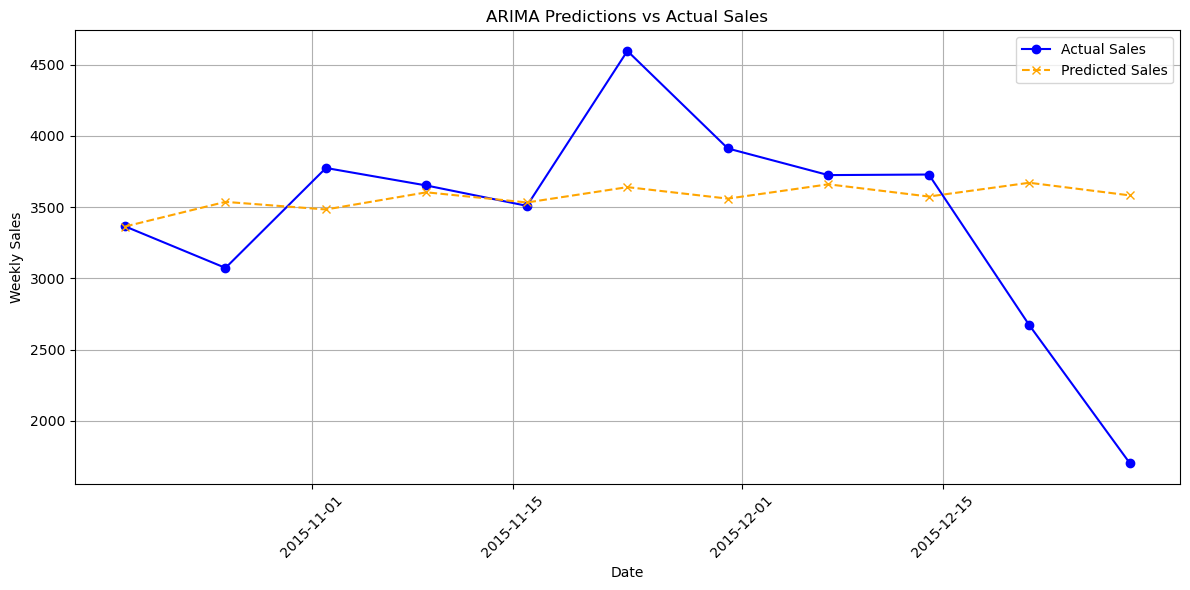

In [17]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(arima_predictions.index, arima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('ARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# SARIMA (Seasonal ARIMA)

In [19]:
# Best SARIMA Model Training and Output
def best_sarima_model(train, test):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit(disp=False)
    predictions = model.forecast(steps=len(test))
    sarima_mape = mape(test, predictions)

    print(f"Best SARIMA Model MAPE: {sarima_mape:.4f}")
    return predictions, sarima_mape


sarima_predictions, sarima_mape_score = best_sarima_model(train, test)
sarima_predictions = pd.Series(sarima_predictions, index=test.index)
print("Predictions:")
print(sarima_predictions)

Best SARIMA Model MAPE: 0.1849
Predictions:
order_date
2015-10-19    3251.125624
2015-10-26    3647.292267
2015-11-02    3407.561473
2015-11-09    2750.099062
2015-11-16    3590.353369
2015-11-23    3084.831400
2015-11-30    3327.425464
2015-12-07    3155.896999
2015-12-14    3475.639785
2015-12-21    3266.273812
2015-12-28    2592.941711
Name: predicted_mean, dtype: float64


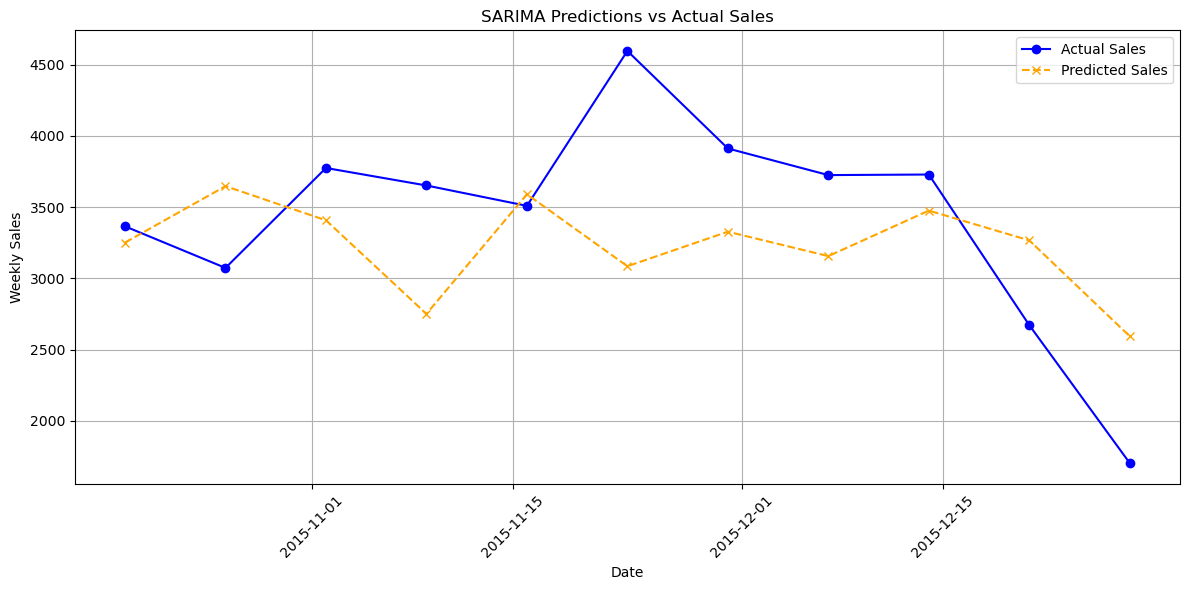

In [21]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(sarima_predictions.index, sarima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('SARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Prophet

In [23]:
# Pizza sales by week
def prepare_weekly_sales_for_prophet(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    weekly_sales.columns = ['ds', 'y']  # this model requires columns 'ds'- date and 'y'- target variable
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales_for_prophet(pizza_sale)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# Best Prophet Model Training and Output
def best_prophet_model(train, test):
    model = Prophet()
    model.fit(train)
    
    future = model.make_future_dataframe(periods=len(test), freq='W')
    forecast = model.predict(future)
    predictions = forecast['yhat'][-len(test):].values
    prophet_mape = mape(test['y'].values, predictions)
    
    print(f"Best Prophet Model MAPE: {prophet_mape:.4f}")
    return predictions, prophet_mape

# Train and evaluate the Prophet model
prophet_predictions, prophet_mape_score = best_prophet_model(train, test)

# Formating the predictions for display
prophet_predictions = pd.Series(prophet_predictions, index=test['ds'])

print("Predictions:")
print(prophet_predictions)

00:44:19 - cmdstanpy - INFO - Chain [1] start processing
00:44:19 - cmdstanpy - INFO - Chain [1] done processing


Best Prophet Model MAPE: 0.1962
Predictions:
ds
2015-10-19    3619.506283
2015-10-26    3618.034527
2015-11-02    3616.562771
2015-11-09    3615.091015
2015-11-16    3613.619259
2015-11-23    3612.147503
2015-11-30    3610.675747
2015-12-07    3609.203991
2015-12-14    3607.732235
2015-12-21    3606.260479
2015-12-28    3604.788723
dtype: float64


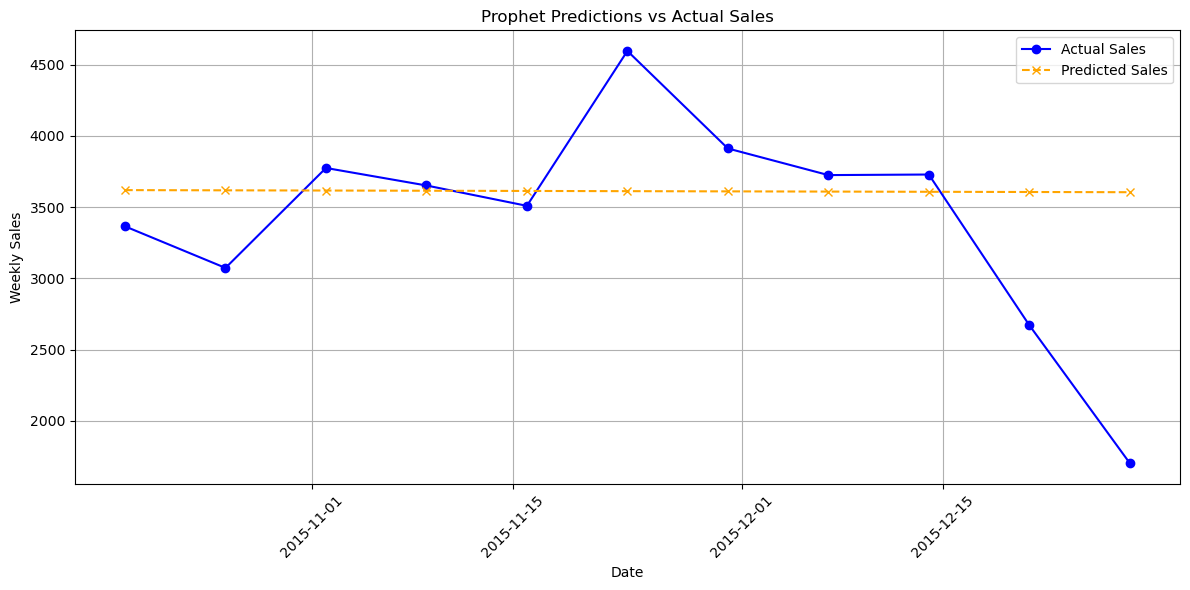

In [25]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], test['y'], label='Actual Sales', color='blue', marker='o')
plt.plot(prophet_predictions.index, prophet_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('Prophet Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# LSTM model

In [27]:
# Pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(pizza_sale)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Normalizeing the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['quantity']])
test_scaled = scaler.transform(test[['quantity']])

# Prepareing data for LSTM
def create_lstm_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 3
X_train, y_train = create_lstm_dataset(train_scaled, time_steps)
X_test, y_test = create_lstm_dataset(test_scaled, time_steps)

# Reshapeing X for LSTM input-Essential for compatibility with LSTM input requirements.
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Training LSTM Model
def best_lstm_model(X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1)) #Adds a fully connected layer with 1 neuron 
    model.compile(optimizer='adam', loss='mse')#adam- Adaptive optimizer for efficient training.

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions) # normalized minmacscalarm-tranformation
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    lstm_mape = mape(y_test_rescaled, predictions)
    
    print(f"Best LSTM Model MAPE: {lstm_mape:.4f}")
    return predictions, lstm_mape, y_test_rescaled

# Train and evaluate the LSTM model
lstm_predictions, lstm_mape_score, y_test_rescaled = best_lstm_model(X_train, y_train, X_test, y_test)

# Formating the predictions for display
lstm_predictions = pd.Series(lstm_predictions.flatten(), index=test['order_date'][time_steps:])

print("Predictions:")
print(lstm_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
Best LSTM Model MAPE: 0.2356
Predictions:
order_date
2015-11-09    3438.425293
2015-11-16    3491.623291
2015-11-23    3639.770020
2015-11-30    3755.321777
2015-12-07    3860.182129
2015-12-14    4018.245117
2015-12-21    3737.263428
2015-12-28    3506.410400
dtype: float32


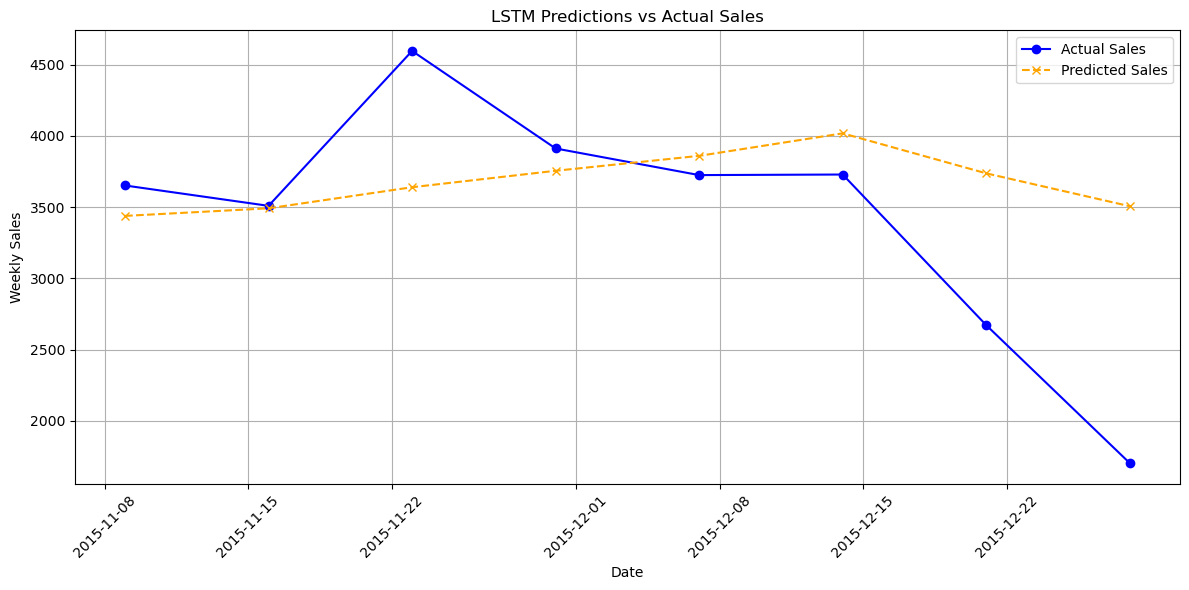

In [29]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['order_date'][time_steps:], y_test_rescaled, label='Actual Sales', color='blue', marker='o')
plt.plot(lstm_predictions.index, lstm_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('LSTM Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# FORECASTED SALES FOR THE WEEK

# ARIMA Model forecasted sales for the week:

In [31]:
# ARIMA Model forecasted sales for the week:

# Aggregate pizza sales by week and pizza type
def prepare_weekly_sales_by_pizza(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['week'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sales_by_pizza = df.groupby(['week', 'pizza_name_id'])['quantity'].sum().reset_index()
    weekly_sales_by_pizza.set_index('week', inplace=True)
    return weekly_sales_by_pizza

pizza_sales_weekly_by_pizza = prepare_weekly_sales_by_pizza(pizza_sale)

# Function to forecast sales for each pizza type using ARIMA
def forecast_sales_per_pizza_type_arima(pizza_type, train, periods=1):
    model = ARIMA(train, order=(0, 0, 1))
    model_fit = model.fit()

    # Forecasting for the next week
    forecast = model_fit.forecast(steps=periods)
    return pizza_type, forecast.tolist()

# Forecasting next week's sales for each pizza type using ARIMA
def forecast_next_week_sales_by_pizza_type_arima(pizza_sales_weekly_by_pizza, periods=1):
    pizza_type_forecasts = {}

    # Total sales per pizza type
    total_units_sold = pizza_sales_weekly_by_pizza.groupby('pizza_name_id')['quantity'].sum()

    # Last week in the dataset
    last_week = pizza_sales_weekly_by_pizza.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Looping through each pizza type
    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]

        # train test split
        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]['quantity']

        # Forecast sales using ARIMA
        pizza_type, forecast = forecast_sales_per_pizza_type_arima(pizza_type, train, periods)

        if forecast is not None:
            pizza_type_forecasts[pizza_type] = forecast
        else:
            print(f"Forecast failed for pizza type: {pizza_type}")

    return pizza_type_forecasts, total_units_sold, next_week_start, next_week_end

# Forecasting pizza sales for the next week using ARIMA
next_week_pizza_sales_forecasts_arima, total_units_sold, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type_arima(pizza_sales_weekly_by_pizza, periods=1)

# Displaying the forecasted sales for each pizza type and the total quantity of units sold in the predicted week
print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")
total_forecasted_quantity = 0

for pizza_type, forecast in next_week_pizza_sales_forecasts_arima.items():
    forecast = int(forecast[0])
    next_week_pizza_sales_forecasts_arima[pizza_type]=forecast
    print(f'{pizza_type}: {forecast} pizzas')
    total_forecasted_quantity += forecast

print(f"Total quantity of units sold in the predicted week: {total_forecasted_quantity} pizzas")

Forecasted sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 96 pizzas
bbq_ckn_m: 91 pizzas
bbq_ckn_s: 27 pizzas
big_meat_s: 107 pizzas
brie_carre_s: 38 pizzas
calabrese_m: 43 pizzas
calabrese_s: 8 pizzas
cali_ckn_l: 84 pizzas
cali_ckn_m: 82 pizzas
cali_ckn_s: 38 pizzas
ckn_alfredo_l: 10 pizzas
ckn_alfredo_m: 63 pizzas
ckn_alfredo_s: 8 pizzas
ckn_pesto_l: 31 pizzas
ckn_pesto_m: 21 pizzas
ckn_pesto_s: 22 pizzas
classic_dlx_l: 26 pizzas
classic_dlx_m: 68 pizzas
classic_dlx_s: 47 pizzas
five_cheese_l: 56 pizzas
four_cheese_l: 117 pizzas
four_cheese_m: 45 pizzas
green_garden_l: 9 pizzas
green_garden_m: 27 pizzas
green_garden_s: 46 pizzas
hawaiian_l: 51 pizzas
hawaiian_m: 27 pizzas
hawaiian_s: 56 pizzas
ital_cpcllo_l: 56 pizzas
ital_cpcllo_m: 31 pizzas
ital_cpcllo_s: 23 pizzas
ital_supr_l: 53 pizzas
ital_supr_m: 66 pizzas
ital_supr_s: 14 pizzas
ital_veggie_l: 22 pizzas
ital_veggie_m: 38 pizzas
ital_veggie_s: 17 pizzas
mediterraneo_l: 38 pizzas
mediterraneo_m: 25 pizzas
mediterraneo_s:

# MODEL EVALUATION

In [33]:
model_performance = {
    'Model': ['ARIMA', 'SARIMA','Prophet','LSTM'],
    'MAPE': [0.1976, 0.2327,0.2163,0.2341]
}

df_performance = pd.DataFrame(model_performance)

#shwoing which model best
df_performance['Rank'] = df_performance['MAPE'].rank()
df_performance = df_performance.sort_values('MAPE', ascending=True)
df_performance['Best/Worst'] = df_performance['MAPE'].apply(lambda x: 'Best' if x == df_performance['MAPE'].min() else 'Worst' if x == df_performance['MAPE'].max() else '')
df_performance

,Model,MAPE,Rank,Best/Worst
0,ARIMA,0.1976,1.0,Best
2,Prophet,0.2163,2.0,
1,SARIMA,0.2327,3.0,
3,LSTM,0.2341,4.0,Worst


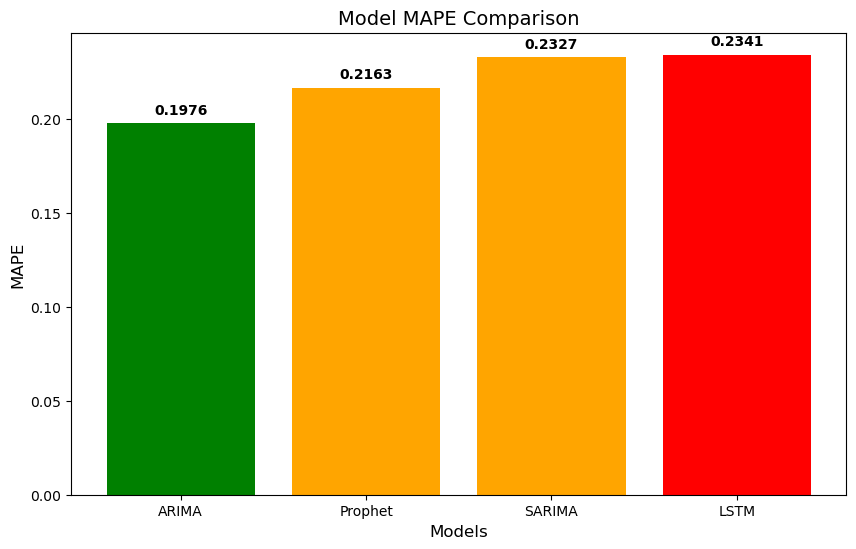

In [35]:
# Visualization and Highlighting the best and worst models
models = ['ARIMA','Prophet','SARIMA', 'LSTM']
mapes = [0.1976,0.2163, 0.2327,0.2341]

plt.figure(figsize=(10,6))
plt.bar(models, mapes, color=['green','orange', 'orange','red'])
plt.title('Model MAPE Comparison', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('MAPE', fontsize=12)

for i, v in enumerate(mapes):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center' ,fontweight='bold')

plt.show()

# HYPERPARAMETER OPTIMIZATION FOR THE BEST-PERFORMING ARIMA MODEL

In [37]:
# Ensure order_date is the index
train.set_index('order_date', inplace=True)

# Passing only the 'quantity' column to auto_arima
auto_model = auto_arima(
    train['quantity'],# Providing univariate time series
    seasonal=True, 
    m=7,  # Weekly seasonality
    trace=True, 
    error_action='ignore', #Ignores errors from invalid parameter combinations
    suppress_warnings=True
)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[7]             : AIC=511.689, Time=0.20 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=514.308, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=505.442, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=505.959, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=505.737, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=506.854, Time=0.11 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=507.009, Time=0.07 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=505.011, Time=0.05 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=507.009, Time=0.13 sec
 ARIMA(1,1,0)(1,1,2)[7]             : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=515.380, Time=0.15 sec
 ARIMA(2,1,0)(0,1,1)[7]             : AIC=506.879, Time=0.12 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=506.392, Time=0.12 sec
 ARIMA(2,1,1)(0,1,1)[7]             : AIC=508.027, Time=0.18 sec
 ARIMA(1,1,0)(0,1,1)[7] intercept   : AIC=505.395, 

# MODEL SAVING WITH PICKLE

In [39]:
model_filename = 'best_arima_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(auto_model, file)
print(f"Model saved as {model_filename}")

Model saved as best_arima_model.pkl


# FINAL RESULTS & PREDICTION

In [41]:
model_filename = 'best_arima_model.pkl'
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Forecasting function to predict weekly sales quantity
def forecast_sales(loaded_model, periods):
    forecast = loaded_model.predict(n_periods=periods)
    return forecast

forecasted_sales = forecast_sales(loaded_model, periods=5)
print(forecasted_sales)

2015-10-19    3213.580075
2015-10-26    3760.607880
2015-11-02    3370.263291
2015-11-09    2900.604061
2015-11-16    3582.850126
Freq: W-MON, dtype: float64


# FORECASTING REPORT VISUALIZATION

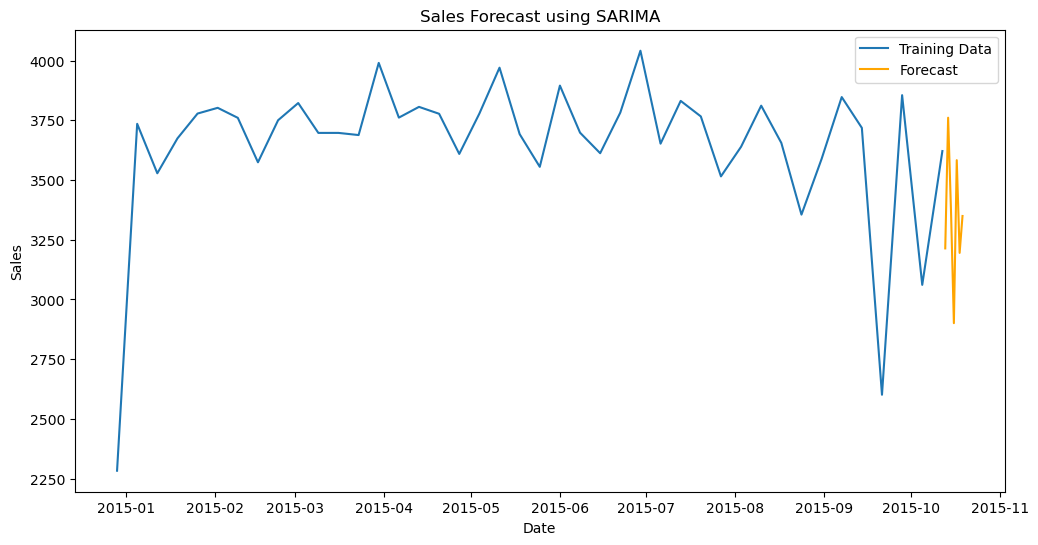

In [45]:
# Loading the best model
with open('best_arima_model.pkl', 'rb') as file:
    best_model = pickle.load(file)

# Forecasting the data
n_forecast = 7
forecast = best_model.predict(n_periods=n_forecast)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), periods=n_forecast), forecast, label='Forecast', color='orange')
plt.title('Sales Forecast using SARIMA')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# PREDICTED INGREDIENT QUANTITY CALCULATION AND DISPLAY

In [ ]:
# Ingredient Quantity Calculation

In [47]:
Ingredients_dataset=pd.read_csv('Pizza_ingredients - Pizza_ingredients.csv')

In [49]:
# Copy ingredients, map predicted sales, and calculateing the total ingredient quantity
ingredients_predicted = Ingredients_dataset.copy()
ingredients_predicted['predicted_quantity'] = ingredients_predicted['pizza_name_id'].map(next_week_pizza_sales_forecasts_arima)
ingredients_predicted['total_ingredient_qty'] = ingredients_predicted['Items_Qty_In_Grams'] * ingredients_predicted['predicted_quantity']
ingredients_predicted.head()

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams,predicted_quantity,total_ingredient_qty
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0,96,3840.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0,96,1440.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0,96,1920.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0,96,2880.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0,96,5760.0


In [51]:
# Sum of the quantities for each ingredient
ingredient_totals = ingredients_predicted.groupby('pizza_ingredients')['total_ingredient_qty'].sum().to_dict()
print("Total quantity of predicted ingredients for the following week:")
ingredient_totals

Total quantity of predicted ingredients for the following week:


{'?duja Salami': 3080.0,
 'Alfredo Sauce': 1225.0,
 'Anchovies': 3250.0,
 'Artichokes': 10865.0,
 'Arugula': 715.0,
 'Asiago Cheese': 6230.0,
 'Bacon': 28320.0,
 'Barbecue Sauce': 2485.0,
 'Barbecued Chicken': 7110.0,
 'Beef Chuck Roast': 13700.0,
 'Blue Cheese': 1680.0,
 'Brie Carre Cheese': 1140.0,
 'Calabrese Salami': 15250.0,
 'Capocollo': 64250.0,
 'Caramelized Onions': 0.0,
 'Chicken': 80600.0,
 'Chipotle Sauce': 7220.0,
 'Chorizo Sausage': 5350.0,
 'Cilantro': 3610.0,
 'Coarse Sicilian Salami': 11360.0,
 'Corn': 24180.0,
 'Eggplant': 3180.0,
 'Feta Cheese': 11230.0,
 'Fontina Cheese': 6040.0,
 'Friggitello Peppers': 770.0,
 'Garlic': 24850.0,
 'Genoa Salami': 9240.0,
 'Goat Cheese': 13440.0,
 'Gorgonzola Piccante Cheese': 5580.0,
 'Gouda Cheese': 4540.0,
 'Green Olives': 4735.0,
 'Green Peppers': 7140.0,
 'Italian Sausage': 1070.0,
 'Jalapeno Peppers': 5880.0,
 'Kalamata Olives': 3515.0,
 'Luganega Sausage': 5680.0,
 'Mozzarella Cheese': 11870.0,
 'Mushrooms': 26060.0,
 'Onions'

In [53]:
# dict into a Pandas DataFrame
ingredient_df = pd.DataFrame(list(ingredient_totals.items()), columns=['Ingredient', 'Total Quantity (grams)'])

In [55]:
ingredient_df

,Ingredient,Total Quantity (grams)
0,?duja Salami,3080.0
1,Alfredo Sauce,1225.0
2,Anchovies,3250.0
3,Artichokes,10865.0
4,Arugula,715.0
...,...,...
59,Sun-dried Tomatoes,1560.0
60,Thai Sweet Chilli Sauce,4160.0
61,Thyme,190.0
62,Tomatoes,49600.0


# Visualizing the Total Tuantities of Ingredients with Data Points

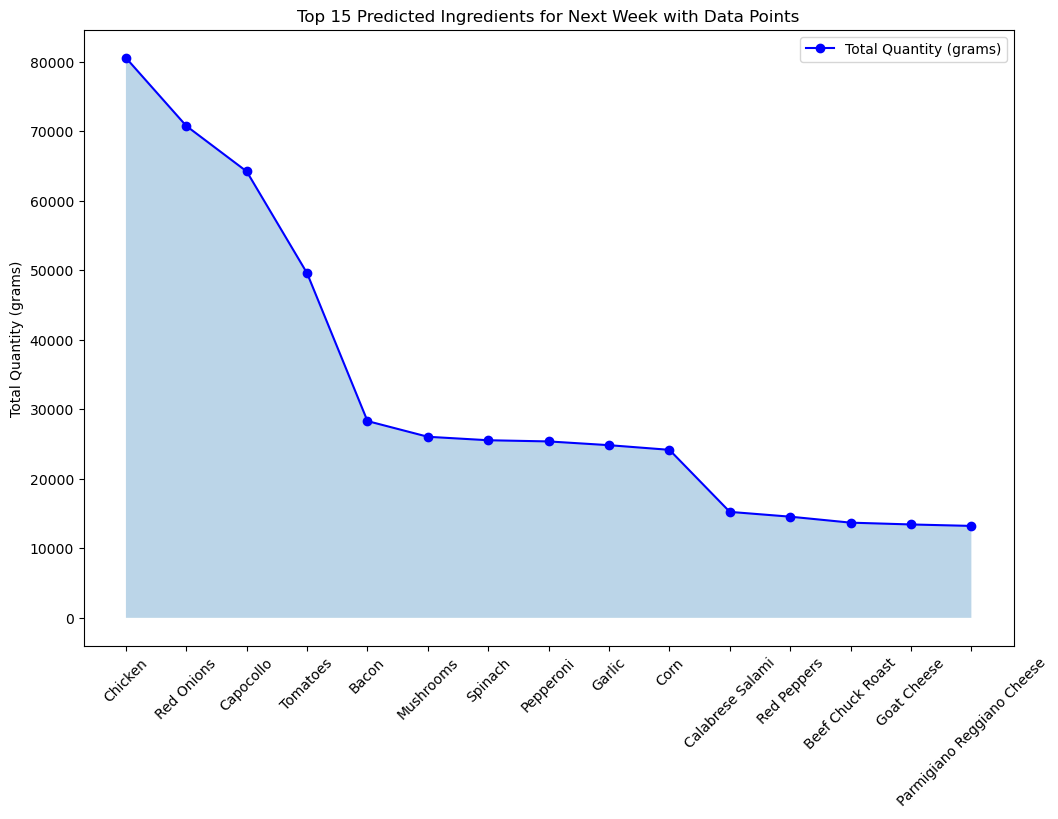

In [57]:
plt.figure(figsize=(12, 8))
top_ingredients = ingredient_df.nlargest(15, 'Total Quantity (grams)')

# Plotting with data points
plt.plot(top_ingredients['Ingredient'], top_ingredients['Total Quantity (grams)'], marker='o', color='b', linestyle='-', label='Total Quantity (grams)')
plt.fill_between(top_ingredients['Ingredient'], top_ingredients['Total Quantity (grams)'], alpha=0.3)
plt.title('Top 15 Predicted Ingredients for Next Week with Data Points')
plt.ylabel('Total Quantity (grams)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
# Saving the Ingredients Total to a DF

In [59]:
ingredient_df = pd.DataFrame(ingredient_totals.items(), columns=['Ingredient', 'Total Quantity (grams)'])
ingredient_df.to_csv('predicted_ingredient_totals.csv', index=False)
print("Predicted ingredient totals saved to 'predicted_ingredient_totals.csv'")

Predicted ingredient totals saved to 'predicted_ingredient_totals.csv'


In [61]:
predicted_ingredient_totals = pd.read_csv('predicted_ingredient_totals.csv')
predicted_ingredient_totals

,Ingredient,Total Quantity (grams)
0,?duja Salami,3080.0
1,Alfredo Sauce,1225.0
2,Anchovies,3250.0
3,Artichokes,10865.0
4,Arugula,715.0
...,...,...
59,Sun-dried Tomatoes,1560.0
60,Thai Sweet Chilli Sauce,4160.0
61,Thyme,190.0
62,Tomatoes,49600.0
